# Project: an interpretable VAE to study Transcription Factor rewiring

## Goal
The goal of this project is to study Transcription factor rewiring in the context of interferon-beta response. Since VAEs are probabilistic, you will end up with a different set of weights each time you train the model. Thus, your task will also be to estimate or compute uncertainties for the weights. There are different ways to achieve this:


*   Train each model multiple times (and then compute metrics such as mean and standard deviation for the different weights). Are there genes whose annotation to a given TF seems to be "less certain" than for others.
*   When we train multiple models and then aggregate their results, we also call this an ensemble. Training an ensemble is often expensive in terms of computational time and power. Stochastic Weight Averaging (SWA) has been proposed as a method that can yield more robust weights without the need of training ensembles. The publication is linked [here](https://arxiv.org/pdf/1803.05407), and additional information can be found [here](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/). Try to implement this approach for your VEGA model.
*   Bayesian Neural Networks do built-in estimation of weight uncertainties. Try to replace your linear layer with a Bayesian layer to obtain these estimates. You can find some information to get you started [in this blogpost](https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825/). More mathematical foundations can also be found [here](https://www.cs.toronto.edu/~duvenaud/distill_bayes_net/public/).

# Load packages and dataset

In [1]:
!pip install scanpy
!pip install omnipath
!pip install decoupler
!pip install torchbnn

## NEW PACKAGES
import os
import polars as pl   # install polars!!



import torch
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from collections import OrderedDict, defaultdict
from collections import Counter

import decoupler as dc
import omnipath as op

device = 'cuda'

c:\Users\chuab\anaconda3\envs\vae\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
  File "c:\Users\chuab\anaconda3\envs\vae\Lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "c:\Users\chuab\anaconda3\envs\vae\Lib\site-packages\urllib3\connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chuab\anaconda3\envs\vae\Lib\http\client.py", line 1430, in getresponse
    response.begin()
  File "c:\Users\chuab\anaconda3\envs\vae\Lib\http\client.py", line 331, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\chuab\anaconda3\envs\vae\Lib\http\client.py", line 292, in _read_status
    line = str(self.fp.rea

In [2]:
!pip install gdown
import gdown

gdown.download(
    "https://drive.google.com/uc?id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG",
    "PBMC_train.h5ad",
    quiet=False
)

PBMC_train = sc.read_h5ad("PBMC_train.h5ad")

gdown.download(
    "https://drive.google.com/uc?id=1rJKZYIG7rv7BQbDD9RElYOgHcxxzjcYj",
    "PBMC_valid.h5ad",
    quiet=False
)

PBMC_valid = sc.read_h5ad("PBMC_valid.h5ad")


Downloading...
From: https://drive.google.com/uc?id=1zHJKoU8QcQB4cLR-oICO2YY4Nu-QaZHG
To: c:\Users\chuab\Desktop\Hackathon\PBMC_train.h5ad
100%|██████████| 45.3M/45.3M [00:03<00:00, 11.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rJKZYIG7rv7BQbDD9RElYOgHcxxzjcYj
To: c:\Users\chuab\Desktop\Hackathon\PBMC_valid.h5ad
100%|██████████| 10.9M/10.9M [00:00<00:00, 11.4MB/s]


In [3]:

# dc.op does not work for me
regulons = dc.get_collectri(organism='human', split_complexes=False)

filtered_regulons = regulons[regulons['source'].isin(
    [
      "GTF2I",
      "GTF3A",
      "NRF1",
      "ELF1",
      "STAT1",
      "STAT2",
      "IRF9",
      "STAT3",
      "STAT4",
      "STAT5A",
      "STAT5B",
      "IRF3",
      "IRF7",
      "IRF1",
      "IRF5",
     "IRF8",
     ])]

"""
['IRF1', 'IRF2', 'IRF2BPL', 'IRF3', 'IRF4', 'IRF5', 'IRF6', 'IRF7','IRF8', 'IRF9', 'STAT1', 'STAT2', 'STAT3', 'STAT4', 'STAT5A','STAT5B', 'STAT6','GTF2I','RUNX1', 'MYOD1', 'SOX2','KLF4', 'THAP11','ADNP2', 'AEBP1','AHRR', 'ALX4','APBB1','APEX1', 'ARHGAP35','ARID1A']
"""

"\n['IRF1', 'IRF2', 'IRF2BPL', 'IRF3', 'IRF4', 'IRF5', 'IRF6', 'IRF7','IRF8', 'IRF9', 'STAT1', 'STAT2', 'STAT3', 'STAT4', 'STAT5A','STAT5B',\xa0'STAT6','GTF2I','RUNX1', 'MYOD1', 'SOX2','KLF4', 'THAP11','ADNP2', 'AEBP1','AHRR', 'ALX4','APBB1','APEX1', 'ARHGAP35','ARID1A']\n"

# VEGA Architecture

**VEGA model**
- a variational autoencoder model enhanced by gene annotations
- users can provide prior knowledge of gene to the *decoder* e.g. gene regulatory network
- allowing the latent variables to be directly interpretable

**Encoder**
- Two fully connected layer with dropout
- Since we are building a variational autoencoder which aims to learn a *probabilistic* latent space, we use a reparameterization trick.
 - Reparameterization trick is needed because backpropagation is computationally challenging when the latent space is probabilistic
 - So, we decompose the latent variable into $ z = \mu+\epsilon\cdot\sigma, \text{where } \epsilon \sim N(0,1)$. Then, gradients can be computed as the random variable $\epsilon$, independent of learnable parameters of the network ($\phi$ for encoder, $\theta$ for decoder).

**Decoder**
- to achieve biological interpretability, we must provide a gene module that defines how the nodes in decoder layers are connected
- this definition is fed to the model by creating a *mask*


**Dataset?**
- we use CollecTRI dataset to define transcriptional regulatory interactions (which TF targets which genes)

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout


        self.mu = nn.Sequential(nn.Linear(800, latent_dims),
                                nn.Dropout(p = z_dropout))

        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)     # epsilon(error)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.mu(x)
        sigma = torch.exp(self.sigma(x)) # exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)  # reparameterization trick
        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z
    # The output parameterizes a Gaussian distribution for each TF.
    # reparameterization trick and a KL-divergence penalty, we create a regularized Bayesian latent space to take into account uncertainty for latent variable

In [5]:

# rows should correspond to genes
# cols should correspond to gene sets/TFs
def create_mask(pbmc_train, pbmc_val, filtered_regulons, extra_nodes_count=1):
    '''
    filtered_regulons: collectri regulons filtered to contain only selected TFs
    pbmc_train: AnnData object
    pbmc_val: AnnData object
    extra_nodes_count: number of additional unannotated nodes to add to the mask

    Outputs:
    mask: torch tensor of shape (n_genes, n_TFs + extra_nodes_count)
    mask_df: polars DataFrame with the same shape as mask, containing the TFs as columns and genes as rows
    train: AnnData object with the same genes as mask_df
    valid: AnnData object with the same genes as mask_df
    '''
####FOR DTYPE COMPATIBILITY
    filtered_regulons = filtered_regulons.astype({
        "source": str,
        "target": str,
        "weight": np.float64
    })

    tmp = (
        pl
        .from_pandas(filtered_regulons)
        # alice and kerem and yusuf decided to convert all -1 to 1 and remove positive weights restriction
        .with_columns(
            pl.col("weight").replace(-1, 1)
        )
        .filter(
            pl.col("target").is_in(pbmc_train.var.index.to_numpy())
        )  # 901 x 13 -> 332 x 13
        .pivot(
            on="source",  # new columns
            index="target",  # stays in rows
            values="weight"
        )
        .fill_null(0)
    )

    for i in range(0, extra_nodes_count):
        node_index = i + 1
        node_name = "unannotated_" + str(node_index)
        tmp = tmp.with_columns(
            pl.lit(1).alias(node_name)
        )


    train = pbmc_train[:, tmp["target"].to_list()].copy()
    valid = pbmc_val[:, tmp["target"].to_list()].copy()

    return tmp, train, valid

In [6]:
# define VEGA's decoder

class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (one-layer, sparse linear, positive)
  """
  def __init__(self,
               mask, soft_penalty):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask, soft_penalty)) # we define the architecture of the decoder below with the class "SparseLayer"

  def forward(self, x):
    z = self.sparse_layer(x.to(device))
    return(z)

  def positive_weights(self):
      """
      constrain the decoder to positive weights (set negative weigths to zero)
      """
      w = self.sparse_layer[0].weight
      w.data = w.data.clamp(0)
      return w


# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask, soft_penalty):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0]))
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1]))
        self.soft_penalty = soft_penalty

        self.reset_parameters()

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

        # mask weight
        self.weight.data = self.weight.data * self.mask

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask, self.soft_penalty)


######### You don't need to understand this part of the code in detail #########
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask, soft_penalty):
        ctx.soft_penalty = soft_penalty
        weight = weight * (mask != 0) # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask, None

In [7]:
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask, soft_penalty=0.1)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# Training functions

In [8]:
### training loop
def trainVEGA_with_valid(vae, data, val_data, epochs=100, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta* vae.encoder.kl
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder to positive weights
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop
        vae.eval()

        for x in val_data:
            x = x.to(device)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
            valid_loss_e += loss.to('cpu').detach().numpy()
        valid_losses.append(valid_loss_e/(len(val_data)*128))

        if epoch % 10 == 0:
            print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128), "  valid_loss: ", valid_loss_e/(len(val_data)*128))

    return vae, train_losses, valid_losses

In [9]:
def get_weight(vae):
  vae.eval()
  return vae.decoder.sparse_layer[0].weight.data.cpu().numpy()

# TODO: Implement Stochastic Weight Averaging (SWA)

* aggregates predictions of multiple models by SWA e.g.
  (cond1, cond2, ..) and (ctrl1, ctrl2, ..)
* can yield more robust weights
* SWA performs an equal average of the weights traversed by SGD with a modified learning rate schedule

In [10]:
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn

def trainVEGA_with_swa(vae, data, val_data, epochs=100, beta=0.0001,
                       learning_rate=0.001, swa_start=75, swa_lr=0.05):
    opt = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=5e-4)
    swa_model = AveragedModel(vae)           # will hold the running average
    swa_scheduler = SWALR(opt, swa_lr=swa_lr)

    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        vae.train()
        train_loss_e = 0.
        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
            loss.backward()
            opt.step()
            vae.decoder.positive_weights()
            train_loss_e += loss.detach().cpu().item()

        # start updating our SWA weights
        if epoch >= swa_start:
            swa_model.update_parameters(vae)
            swa_scheduler.step()

        train_losses.append(train_loss_e / (len(data) * data.batch_size))

        # validation
        vae.eval()
        valid_loss_e = 0.
        with torch.no_grad():
            for x in val_data:
                x = x.to(device)
                x_hat = vae(x)
                loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
                valid_loss_e += loss.detach().cpu().item()
        valid_losses.append(valid_loss_e / (len(val_data) * val_data.batch_size))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: train_loss={train_losses[-1]:.4f}, valid_loss={valid_losses[-1]:.4f}")

    # recompute batch‐norm statistics for the SWA model (if you had any)
    update_bn(data, swa_model, device=device)

    return swa_model, train_losses, valid_losses


In [11]:
def get_weight_swa(swa_model):
    """
    Extract the sparse‐decoder weights from an AveragedModel.
    """
    # if it's wrapped in AveragedModel, the averaged params live in swa_model.module
    model = swa_model.module if hasattr(swa_model, "module") else swa_model
    # pull out the sparse‐layer weight matrix
    W = model.decoder.sparse_layer[0].weight.data.cpu().numpy()
    return W

# TODO: Apply Bayesian layer

* replace nn.Linear in Encoder class with bnn.BayesLinear
* use nn.MSELoss() and bnn.BKLLoss() for optimization



In [12]:
def _kl_loss(mu_0, log_sigma_0, mu_1, log_sigma_1) :
    """
    A method for calculating KL divergence between two Normal distribtuion.

    Arguments:
        mu_0 (Float) : mean of normal distribution.
        log_sigma_0 (Float): log(standard deviation of normal distribution).
        mu_1 (Float): mean of normal distribution.
        log_sigma_1 (Float): log(standard deviation of normal distribution).

    """
    kl = log_sigma_1 - log_sigma_0 + \
    (torch.exp(log_sigma_0)**2 + (mu_0-mu_1)**2)/(2*math.exp(log_sigma_1)**2) - 0.5
    return kl.sum()

In [13]:
class BayesDecoder(nn.Module):
    def __init__(self, mask, soft_penalty):
        super(BayesDecoder, self).__init__()
        self.sparse_layer = nn.Sequential(BayesianSparseLayer(mask, soft_penalty))

    def forward(self, x):
        return self.sparse_layer(x.to(device))

    def kl_divergence(self):
        return self.sparse_layer[0].kl_loss()

    def positive_weights(self):
      """
      constrain the decoder to positive weights (set negative weigths to zero)
      """
      w = self.sparse_layer[0].weight_mu
      w.data = w.data.clamp(0)
      return w


class BayesianSparseLayer(nn.Module):
    def __init__(self, mask, soft_penalty):
        super(BayesianSparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)
        self.in_features = mask.shape[0]
        self.out_features = mask.shape[1]

        self.prior_mu = 0
        self.prior_sigma = 0.1
        self.prior_log_sigma = math.log(0.1)

        self.weight_mu = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        self.weight_log_sigma = nn.Parameter(torch.Tensor(self.out_features, self.in_features))

        self.bias_mu = nn.Parameter(torch.Tensor(self.out_features))
        self.bias_log_sigma = nn.Parameter(torch.Tensor(self.out_features))

        self.soft_penalty = soft_penalty

        self.reset_parameters()

    def reset_parameters(self):
        # Initialization method of Adv-BNN
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_log_sigma.data.fill_(self.prior_log_sigma)
        self.bias_mu.data.uniform_(-stdv, stdv)
        self.bias_log_sigma.data.fill_(self.prior_log_sigma)
        # mask weight
        self.weight_mu.data = self.weight_mu.data * self.mask
        self.weight_log_sigma.data = self.weight_log_sigma * self.mask

    def forward(self, input):
        weight = self.weight_mu + torch.exp(self.weight_log_sigma) * torch.randn_like(self.weight_log_sigma) # reparameterization trick again, but for the Weights
        bias = self.bias_mu + torch.exp(self.bias_log_sigma) * torch.randn_like(self.bias_log_sigma)
        return SparseLayerFunction.apply(input, weight, bias, self.mask, self.soft_penalty)

    def kl_loss(self):
        return _kl_loss(self.weight_mu, self.weight_log_sigma,
                        self.prior_mu, self.prior_log_sigma)

class BayesVEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3, soft_penalty = 0.1):
        super(BayesVEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = BayesDecoder(mask, soft_penalty)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [14]:
# Extract the mean regulatory strength (the signal) and the statistical uncertainty (the margin of error) for every transcription factor-to-gene connection learned by the model.

def get_weight_bayes(model):
    # pull out the sparse‐layer weight matrix
    W = model.decoder.sparse_layer[0].weight_mu.data.cpu().numpy()
    return W

def get_weight_uncertainties_bayes(model):
    # pull out the sparse‐layer weight matrix
    W = model.decoder.sparse_layer[0].weight_log_sigma.data.cpu().numpy()
    return W

In [15]:
### training loop
def trainVEGA_with_bayes(vae, data, val_data, epochs=100, beta_en = 0.0001, beta_de = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            kl_encoder = vae.encoder.kl
            kl_decoder = vae.decoder.kl_divergence()

            loss = ((x - x_hat)**2).sum() + beta_en* kl_encoder + beta_de*kl_decoder
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder to positive weights
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop
        vae.eval()

        for x in val_data:
            x = x.to(device)
            x_hat = vae(x)
            kl_encoder = vae.encoder.kl
            kl_decoder = vae.decoder.kl_divergence()
            loss = ((x - x_hat)**2).sum() + beta_en* kl_encoder + beta_de*kl_decoder
            valid_loss_e += loss.to('cpu').detach().numpy()
        valid_losses.append(valid_loss_e/(len(val_data)*128))

        if epoch % 10 == 0:
            print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128), "  valid_loss: ", valid_loss_e/(len(val_data)*128))

    return vae, train_losses, valid_losses

# Split train/valid dataset
We need to train `PBMC_train_ctrl` and `PBMC_train_stim` separately.

In [16]:
# Split data set into control and stimulated
PBMC_train_stim = PBMC_train[PBMC_train.obs["condition"] == "stimulated"]
print("PBMC_train_stim: ", len(PBMC_train_stim))
PBMC_train_ctrl = PBMC_train[PBMC_train.obs["condition"] == "control"]
print("PBMC_train_ctrl: ", len(PBMC_train_ctrl))
PBMC_valid_stim = PBMC_valid[PBMC_valid.obs["condition"] == "stimulated"]
print("PBMC_valid_stim: ", len(PBMC_valid_stim))
PBMC_valid_ctrl = PBMC_valid[PBMC_valid.obs["condition"] == "control"]
print("PBMC_valid_ctrl: ",len(PBMC_valid_ctrl))

PBMC_train_stim:  7109
PBMC_train_ctrl:  6406
PBMC_valid_stim:  1777
PBMC_valid_ctrl:  1601


# TODO: Train basic model (with activator or inhibitor gmt) on vega, swa, bayes
Train each model (cond/ctrl) multiple times (and then compute metrics such as mean and standard deviation for the different weights). Are there genes whose annotation to a given TF seems to be "less certain" than for others?

In [ ]:
def save_losses(train_losses, valid_losses, path, condition):
    os.makedirs(path, exist_ok=True)
    with open(os.path.join(path, f"{condition}, losses.csv"), "w") as f:
        f.write("epoch,train_loss,valid_loss\n")
        for epoch, (train_loss, valid_loss) in enumerate(zip(train_losses, valid_losses)):
            f.write(f"{epoch},{train_loss},{valid_loss}\n")

def run_vega_model(model_type, train_data, valid_data, path_to_save = 'models/vega', cond = 'all', cell_type = 'all', N=10, epochs = 60): # I need this encoder argument
    """
    cond is "stimulated" or "control" or 'all' (I need 'all' to train the encoder before frezeing it) Train the Decoder on Control or Stimulated data.
    model type is 'bayes', 'vega' or 'swa'
    """

    mask_df, train_data, valid_data = create_mask(train_data, valid_data, filtered_regulons)

    # convert mask polars to DF
    numeric_columns = [
    name for name, dtype in mask_df.schema.items()
    if dtype in (pl.Float32, pl.Float64, pl.Int32, pl.Int64)
    ]
    mask = mask_df.select(numeric_columns).to_numpy()
    mask = torch.from_numpy(mask).float()

    # create mask
    if not cond == 'all':
        train_data = train_data[train_data.obs["condition"] == cond]
        valid_data = valid_data[valid_data.obs["condition"] == cond]

    if not cell_type == 'all':
        train_data = train_data[train_data.obs["cell_type"] == cell_type]
        valid_data = valid_data[valid_data.obs["cell_type"] == cell_type]

    # set up dataloader
    trainX = torch.utils.data.DataLoader(train_data.X.toarray(), batch_size=128, shuffle=True)
    validX = torch.utils.data.DataLoader(valid_data.X.toarray(), batch_size=128, shuffle=True)

    all_weights = []

    match model_type:
        case "vega":
            for _ in range(N):
                os.makedirs(path_to_save, exist_ok=True)
                vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, dropout = 0.3, z_dropout = 0.3).to(device)   
                vega, train_losses, valid_losses = trainVEGA_with_valid(vega, trainX, validX, epochs=epochs, beta=0.0001)
                weight = get_weight(vega)
                all_weights.append(weight)
                save_losses(train_losses, valid_losses, path_to_save, cond)  # save a loss function to plot it later

        case "bayes":
            weight_uncertainties = []
            for _ in range(N):
                os.makedirs(path_to_save, exist_ok=True)
                vega = BayesVEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, dropout = 0.3,  z_dropout = 0.3).to(device)         
                vega, train_losses, valid_losses = trainVEGA_with_bayes(vega, trainX, validX, epochs = epochs, beta_en = 0.0001, beta_de=0.0001)
                weight = get_weight_bayes(vega)
                uncertainty = get_weight_uncertainties_bayes(vega)
                uncertainty = np.exp(uncertainty)
                all_weights.append(weight)
                weight_uncertainties.append(uncertainty)
                save_losses(train_losses, valid_losses, path_to_save, cond)

            weight_uncertainties = np.stack(weight_uncertainties)
            mean_weight_uncertainties = weight_uncertainties.mean(axis=0)
            mean_weight_uncertainties = pd.DataFrame(mean_weight_uncertainties, index = train_data.var.index.tolist(), columns=mask_df.columns[1:])
            mean_weight_uncertainties.to_csv(os.path.join(path_to_save, f"{cond}_{model_type}_{cell_type}_weight_uncertainty_mean.csv"), index=True)

        case "swa":
            for _ in range(N):
                os.makedirs(path_to_save, exist_ok=True)
                vega = VEGA(latent_dims=mask.shape[1],
                        input_dims=mask.shape[0],
                        mask=mask.T,
                        dropout=0.3,
                        z_dropout=0.3).to(device)

                swa_model, train_losses, valid_losses = trainVEGA_with_swa(
                    vega, trainX, validX,
                    epochs=100, beta=0.0001,
                    learning_rate=0.0005,
                    swa_start=80,
                    swa_lr=0.0001
                )

                W_swa = get_weight_swa(swa_model)
                all_weights.append(W_swa)
                save_losses(train_losses, valid_losses, path_to_save, cond)


    
    stacked = np.stack(all_weights)
    mean_weight = stacked.mean(axis=0)
    std_weight = stacked.std(axis=0)

    mean_weight = pd.DataFrame(mean_weight, index = train_data.var.index.tolist(), columns=mask_df.columns[1:])
    std_weight = pd.DataFrame(std_weight, index = train_data.var.index.tolist(), columns=mask_df.columns[1:])


    mean_weight.to_csv(os.path.join(path_to_save, f"{cond}_{model_type}_{cell_type}_weight_mean.csv"), index=True)
    std_weight.to_csv(os.path.join(path_to_save, f"{cond}_{model_type}_{cell_type}_weight_std.csv"), index=True)

    return vega, mean_weight, std_weight

C:\Users\chuab\AppData\Local\Temp\ipykernel_34020\109680428.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)


epoch:  0  train_loss:  55.54374335793888   valid_loss:  44.67210622934195
epoch:  10  train_loss:  24.869033130944945   valid_loss:  19.952685282780575
epoch:  20  train_loss:  22.66052414155474   valid_loss:  18.81109178983248
epoch:  30  train_loss:  21.688346532045625   valid_loss:  18.806545697725735
epoch:  40  train_loss:  21.414040823777515   valid_loss:  18.466292674724873
epoch:  50  train_loss:  21.241980145959293   valid_loss:  18.668278547433708


C:\Users\chuab\AppData\Local\Temp\ipykernel_34020\109680428.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False)


epoch:  0  train_loss:  89.74369859695435   valid_loss:  67.99734578813825
epoch:  10  train_loss:  37.06718356268747   valid_loss:  29.63515499659947
epoch:  20  train_loss:  33.148615564618794   valid_loss:  27.324080603463308
epoch:  30  train_loss:  31.26705925805228   valid_loss:  25.918476104736328
epoch:  40  train_loss:  30.29291684286935   valid_loss:  25.0396945135934
epoch:  50  train_loss:  29.575575981821334   valid_loss:  24.990280287606375


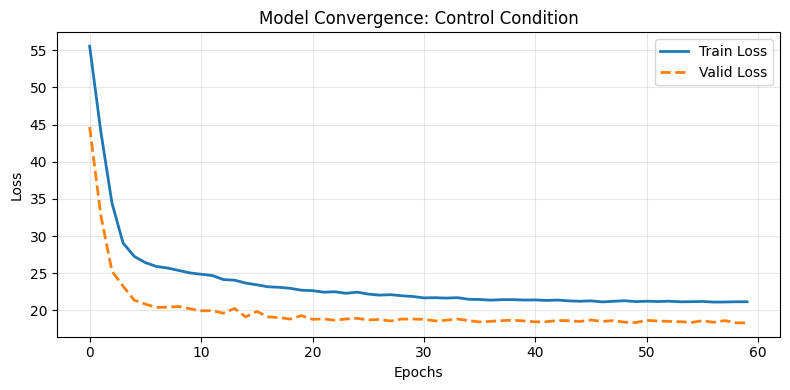

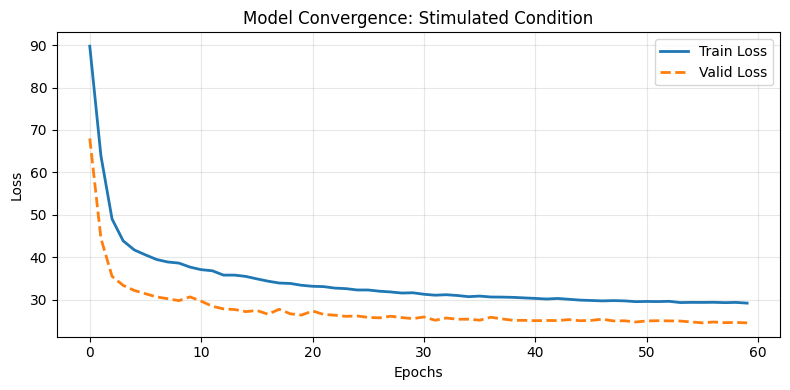

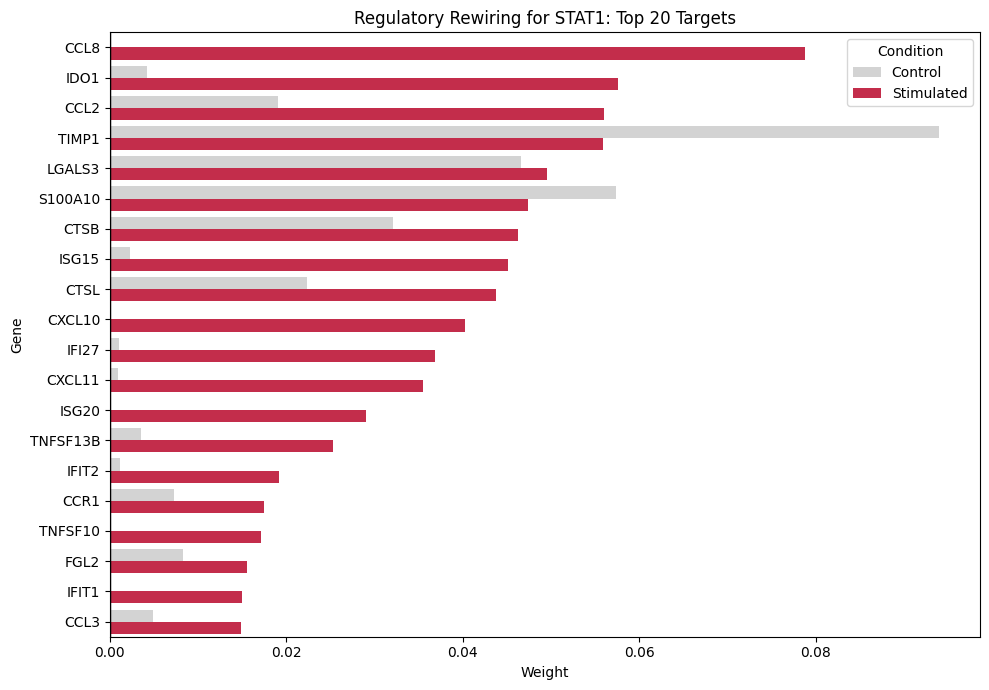

In [35]:
import seaborn as sns
SAVE_DIR = r"C:\Users\chuab\Desktop\Hackathon\models"

# Control
vega_ctrl, mean_ctrl, std_ctrl = run_vega_model(
    model_type="vega",
    train_data=PBMC_train_ctrl,
    valid_data=PBMC_valid_ctrl,
    path_to_save=SAVE_DIR,
    cond="control",
    cell_type="all",
    N=1,
    epochs=60
)

# Stimulated
vega_stim, mean_stim, std_stim = run_vega_model(
    model_type="vega",
    train_data=PBMC_train_stim,
    valid_data=PBMC_valid_stim,
    path_to_save=SAVE_DIR,
    cond="stimulated",
    cell_type="all",
    N=1,
    epochs=60
)

def plot_loss_curves(path, condition):
    """Reads the saved losses.csv and plots Train vs Validation loss."""
    file_path = os.path.join(path, f"{condition}, losses.csv")
    
    if not os.path.exists(file_path):
        print(f"Loss file not found for: {condition}")
        return

    losses = pd.read_csv(file_path)

    plt.figure(figsize=(8, 4))
    plt.plot(losses['epoch'], losses['train_loss'], label='Train Loss', color='#1f77b4', lw=2)
    plt.plot(losses['epoch'], losses['valid_loss'], label='Valid Loss', color='#ff7f0e', lw=2, linestyle='--')
    
    plt.title(f"Model Convergence: {condition.capitalize()} Condition")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_tf_weights(mean_ctrl, mean_stim, tf_name, top_n=20):
    """Plots a comparison of top gene weights for a specific TF."""
    # Identify the most relevant genes based on the Stimulated condition
    top_genes = mean_stim[tf_name].sort_values(ascending=False).head(top_n).index
    
    df_plot = pd.DataFrame({
        'Gene': top_genes,
        'Control': mean_ctrl.loc[top_genes, tf_name],
        'Stimulated': mean_stim.loc[top_genes, tf_name]
    }).melt(id_vars='Gene', var_name='Condition', value_name='Weight')

    plt.figure(figsize=(10, 7))
    sns.barplot(data=df_plot, x='Weight', y='Gene', hue='Condition', palette={'Control': 'lightgray', 'Stimulated': 'crimson'})
    plt.title(f"Regulatory Rewiring for {tf_name}: Top {top_n} Targets")
    plt.axvline(0, color='black', lw=1)
    plt.tight_layout()
    plt.show()

# First, check the training quality
plot_loss_curves(SAVE_DIR, "control")
plot_loss_curves(SAVE_DIR, "stimulated")

# Second, visualize the biological results (The Rewiring)
plot_tf_weights(mean_ctrl, mean_stim, tf_name="STAT1")

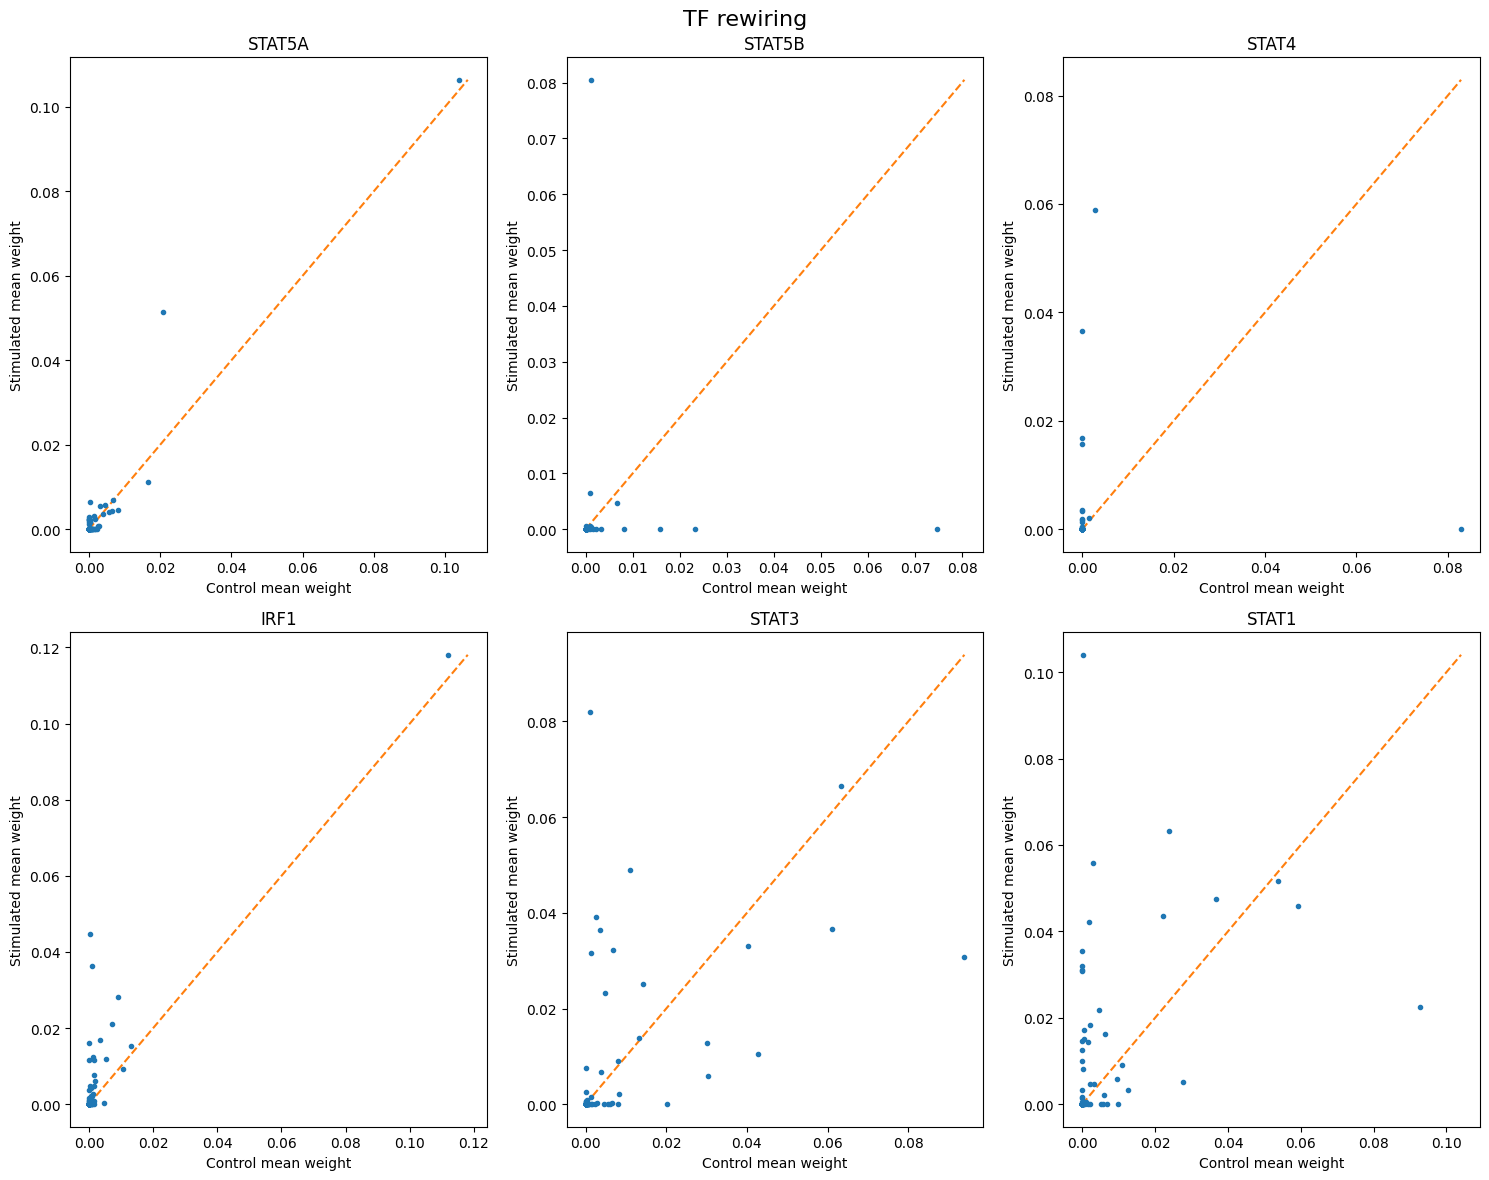

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os



def plot_tf_rewiring(path, tf_names, title, n_cols=3, figsize=(15, 12)):

    mean_weights_ctrl = None
    mean_weights_stim = None
    sigma_weights_ctrl = None
    sigma_weights_stim = None

    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)

        if filename.endswith("weight_mean.csv"):
            if "control" in filename:
                mean_weights_ctrl = pd.read_csv(file_path, index_col=0)
            elif "stimulated" in filename:
                mean_weights_stim = pd.read_csv(file_path, index_col=0)

        if filename.endswith("weight_std.csv"):
            if "control" in filename:
                sigma_weights_ctrl = pd.read_csv(file_path, index_col=0)
            elif "stimulated" in filename:
                sigma_weights_stim = pd.read_csv(file_path, index_col=0)

    if any(v is None for v in [mean_weights_ctrl, mean_weights_stim,
                              sigma_weights_ctrl, sigma_weights_stim]):
        raise FileNotFoundError("Missing Vega files in folder")

    n_plots = len(tf_names)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    fig.suptitle(title, fontsize=16)

    for idx, tf_name in enumerate(tf_names):
        row, col = divmod(idx, n_cols)
        ax = axs[row][col]

        if tf_name not in mean_weights_ctrl.columns:
            ax.set_visible(False)
            continue

        stim = mean_weights_stim[tf_name]
        ctrl = mean_weights_ctrl[tf_name]
        std_stim = sigma_weights_stim[tf_name]
        std_ctrl = sigma_weights_ctrl[tf_name]

        merged = pd.concat(
            [ctrl.rename("ctrl"),
             stim.rename("stim"),
             std_ctrl.rename("std_ctrl"),
             std_stim.rename("std_stim")],
            axis=1
        ).dropna()

        if merged.empty:
            ax.set_visible(False)
            continue

        ax.errorbar(
            merged["ctrl"], merged["stim"],
            xerr=merged["std_ctrl"], yerr=merged["std_stim"],
            fmt='.'
        )

        mn = min(merged["ctrl"].min(), merged["stim"].min())
        mx = max(merged["ctrl"].max(), merged["stim"].max())
        ax.plot([mn, mx], [mn, mx], linestyle='--')

        ax.set_xlabel("Control mean weight")
        ax.set_ylabel("Stimulated mean weight")
        ax.set_title(tf_name)

    plt.tight_layout()
    plt.show()

plot_tf_rewiring(
    path="C:/Users/chuab/Desktop/Hackathon/models",
    tf_names=['STAT5A','STAT5B','STAT4','IRF1','STAT3','STAT1'],
    title="TF rewiring"
)

# Train model with merged mask


In [21]:
def create_merged_mask(adata, activator_gmt, inhibitor_gmt, add_nodes:int=1, sep='\t'):

    activator_dict = OrderedDict()
    if activator_gmt is not None:
        with open(activator_gmt) as f:
            for line in f.readlines():
                line = line.strip()
                spli = line.split(sep)
                activator_dict[spli[0]] = spli[2:]

    inhibitor_dict = OrderedDict()
    if inhibitor_gmt is not None:
        with open(inhibitor_gmt) as f:
            for line in f.readlines():
                line = line.strip()
                spli = line.split(sep)
                inhibitor_dict[spli[0]] = spli[2:]

    feature_list = adata.var.index.tolist()

    unique_keys = set(activator_dict.keys()) | set(inhibitor_dict.keys())

    # Create mask
    mask = np.zeros((len(feature_list), len(unique_keys)))
    for j, k in enumerate(activator_dict.keys()):
        for i in range(mask.shape[0]):
            if feature_list[i] in activator_dict[k]:      # match genes
                mask[i,j] = 1.      # 1 means target is stimulated by TF, 0 means target is not affected by TF

    for j, k in enumerate(inhibitor_dict.keys()):
        for i in range(mask.shape[0]):
            if feature_list[i] in inhibitor_dict[k]:      # match genes
                mask[i,j] = -1.

     # Add unannotated nodes
    vec = np.ones((mask.shape[0], add_nodes))
    mask = np.hstack((mask, vec))

    adata = adata.copy()
    adata.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = mask
    adata.uns['_vega']['gmv_names'] = list(unique_keys) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]

    return adata, mask

### 1. Basic model + merged mask

In [22]:
class MergedDecoderVEGA(nn.Module):
    """
    Define VEGA's decoder (sparse, one-layer, linear, positive)
    """
    def __init__(self, mask, soft_penalty):
        super(MergedDecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(MergedSparseLayer(mask, soft_penalty)) # we define the architecture of the decoder below with the class "SparseLayer"

    def forward(self, x):
        z = self.sparse_layer(x.to(device))
        return(z)

# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class MergedSparseLayer(SparseLayer):
    def __init__(self, mask, soft_penalty):
        """
        Extended torch.nn module which mask connection
        """
        super().__init__(mask, soft_penalty)

        self.activator_mask = (self.mask == 1).float()
        self.inhibitor_mask = (self.mask == -1).float()
        self.zero_mask = (self.mask == 0).float()
        self.soft_penalty = self.soft_penalty

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def constrain_weights(self):
        with torch.no_grad():
            # Clamp activator weights to be >= 0
            device = self.weight.device

            a_mask = self.activator_mask.to(device)
            i_mask = self.inhibitor_mask.to(device)
            z_mask = self.zero_mask.to(device)

            self.weight.data = self.weight.data * (1 - a_mask) + \
                               self.weight.data.clamp(min=0) * a_mask

            # Clamp inhibitor weights to be <= 0
            self.weight.data = self.weight.data * (1 - i_mask) + \
                               self.weight.data.clamp(max=0) * i_mask

            # Set zero-regulation weights to exactly zero
            self.weight.data = self.weight.data * (1 - z_mask)

    def forward(self, input):
        # See the autograd section for explanation of what happens here
        return MergedSparseLayerFunction.apply(input, self.weight, self.bias, self.mask, self.soft_penalty)


######### You don't need to understand this part of the code in detail #########
class MergedSparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask, soft_penalty=0.1):
        ctx.soft_penalty = soft_penalty
        return SparseLayerFunction.forward(ctx, input, weight, bias, mask, soft_penalty)

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        soft_penalty = ctx.soft_penalty
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight * (mask != 0))
        if ctx.needs_input_grad[1]:
            raw_grad_weight = grad_output.t().mm(input)

            grad_weight = torch.zeros_like(raw_grad_weight)

            # Activators (mask = 1): allow positive weights, penalize negatives
            activator_mask = (mask == 1)
            grad_weight += activator_mask * raw_grad_weight
            grad_weight -= activator_mask * (weight < 0).float() * weight.abs() * soft_penalty  # soft penalty

            # Inhibitors (mask = -1): allow negative weights, penalize positives
            inhibitor_mask = (mask == -1)
            grad_weight += inhibitor_mask * raw_grad_weight
            grad_weight += inhibitor_mask * (weight > 0).float() * weight.abs() * soft_penalty  # soft penalty

            # Zeros: do not update
            grad_weight *= (mask != 0).float()

        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, None, None

In [23]:
class MergedVEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3, soft_penalty = 0.1):
        super(MergedVEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = MergedDecoderVEGA(mask, soft_penalty)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [24]:
### training loop
def trainMergedVEGA_with_valid(vae, data, val_data, epochs=100, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta* vae.encoder.kl
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.sparse_layer[0].constrain_weights() # we restrict the decoder to positive weights
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop
        vae.eval()

        for x in val_data:
            x = x.to(device)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
            valid_loss_e += loss.to('cpu').detach().numpy()
        valid_losses.append(valid_loss_e/(len(val_data)*128))

        if epoch % 10 == 0:
            print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128), "  valid_loss: ", valid_loss_e/(len(val_data)*128))

    return vae, train_losses, valid_losses



### 2. SWA model + merged mask

In [25]:
def trainMergedVEGA_with_swa(vae, data, val_data, epochs=100, beta=0.0001,
                       learning_rate=0.001, swa_start=75, swa_lr=0.05):
    opt = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=5e-4)
    swa_model = AveragedModel(vae)           # will hold the running average
    swa_scheduler = SWALR(opt, swa_lr=swa_lr)

    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        vae.train()
        train_loss_e = 0.
        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
            loss.backward()
            opt.step()
            vae.decoder.sparse_layer[0].constrain_weights()
            train_loss_e += loss.detach().cpu().item()

        # start updating our SWA weights
        if epoch >= swa_start:
            swa_model.update_parameters(vae)
            swa_scheduler.step()

        train_losses.append(train_loss_e / (len(data) * data.batch_size))

        # validation
        vae.eval()
        valid_loss_e = 0.
        with torch.no_grad():
            for x in val_data:
                x = x.to(device)
                x_hat = vae(x)
                loss = ((x - x_hat)**2).sum() + beta * vae.encoder.kl
                valid_loss_e += loss.detach().cpu().item()
        valid_losses.append(valid_loss_e / (len(val_data) * val_data.batch_size))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: train_loss={train_losses[-1]:.4f}, valid_loss={valid_losses[-1]:.4f}")

    # recompute batch‐norm statistics for the SWA model (if you had any)
    update_bn(data, swa_model, device=device)

    return swa_model, train_losses, valid_losses

### 3. Bayes model + merged mask

In [26]:
class MergedBayesDecoder(nn.Module):
    """
    Define VEGA's decoder (sparse, one-layer, linear, positive)
    """
    def __init__(self, mask, soft_penalty):
        super(MergedBayesDecoder, self).__init__()

        self.sparse_layer = nn.Sequential(MergedBayesianSparseLayer(mask, soft_penalty)) # we define the architecture of the decoder below with the class "SparseLayer"

    def forward(self, x):
        z = self.sparse_layer(x.to(device))
        return(z)

    def kl_divergence(self):
        return self.sparse_layer[0].kl_loss()

# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class MergedBayesianSparseLayer(BayesianSparseLayer):
    def __init__(self, mask, soft_penalty):
        """
        Extended torch.nn module which mask connection
        """
        super(MergedBayesianSparseLayer, self).__init__(mask, soft_penalty)

        self.activator_mask = (self.mask == 1).float()
        self.inhibitor_mask = (self.mask == -1).float()
        self.zero_mask = (self.mask == 0).float()

    def reset_parameters(self):
        # Initialization method of Adv-BNN
        stdv = 1. / math.sqrt(self.weight_mu.size(1))
        self.weight_mu.data.uniform_(-stdv, stdv)
        self.weight_log_sigma.data.fill_(self.prior_log_sigma)
        self.bias_mu.data.uniform_(-stdv, stdv)
        self.bias_log_sigma.data.fill_(self.prior_log_sigma)

    def constrain_weights(self):
        with torch.no_grad():
            # Clamp activator weights to be >= 0
            device = self.weight_mu.device

            a_mask = self.activator_mask.to(device)
            i_mask = self.inhibitor_mask.to(device)
            z_mask = self.zero_mask.to(device)

            self.weight_mu.data = self.weight_mu.data * (1 - a_mask) + \
                               self.weight_mu.data.clamp(min=0) * a_mask

            # Clamp inhibitor weights to be <= 0
            self.weight_mu.data = self.weight_mu.data * (1 - i_mask) + \
                               self.weight_mu.data.clamp(max=0) * i_mask

            # Set zero-regulation weights to exactly zero
            self.weight_mu.data = self.weight_mu.data * (1 - z_mask)


class MergedBayesVEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3, soft_penalty = 0.0001):
        super(MergedBayesVEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = MergedBayesDecoder(mask, soft_penalty)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [27]:
### training loop
def trainMergedVEGA_with_Bayes(vae, data, val_data, epochs=100, beta_en = 0.0001, beta_de = 0.0001, learning_rate = 0.0001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            kl_encoder = vae.encoder.kl
            kl_decoder = vae.decoder.kl_divergence()

            loss = ((x - x_hat)**2).sum() + beta_en* kl_encoder + beta_de*kl_decoder
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.sparse_layer[0].constrain_weights()
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop
        vae.eval()

        for x in val_data:
            x = x.to(device)
            x_hat = vae(x)
            kl_encoder = vae.encoder.kl
            kl_decoder = vae.decoder.kl_divergence()
            loss = ((x - x_hat)**2).sum() + beta_en* kl_encoder + beta_de*kl_decoder
            valid_loss_e += loss.to('cpu').detach().numpy()
        valid_losses.append(valid_loss_e/(len(val_data)*128))

        if epoch % 10 == 0:
            print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128), "  valid_loss: ", valid_loss_e/(len(val_data)*128))

    return vae, train_losses, valid_losses


### Run merged models

In [28]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses, valid_losses, title=None):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="train")
    plt.plot(valid_losses, label="valid")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [29]:
import os

def run_merged_vega_model(
    model_type, train_data, valid_data, cond,
    activator_gmt, inhibitor_gmt, N,
    path_to_save=r"C:\Users\chuab\Desktop\Hackathon\models"
):
    """
    model_type: "vega", "swa", "bayes"
    cond: "stimulated" or "control"
    """
    os.makedirs(path_to_save, exist_ok=True)  # ensure folder exists

    # create mask + filter condition
    train_data, mask = create_merged_mask(train_data, activator_gmt, inhibitor_gmt, add_nodes=1)
    train_data = train_data[train_data.obs["condition"] == cond]
    valid_data = valid_data[valid_data.obs["condition"] == cond]

    # dataloaders
    trainX = torch.utils.data.DataLoader(train_data.X.toarray(), batch_size=128, shuffle=True)
    validX = torch.utils.data.DataLoader(valid_data.X.toarray(), batch_size=128, shuffle=True)

    all_weights = []

    match model_type:
        case "vega":
            for _ in range(N):
                vega = MergedVEGA(
                    latent_dims=mask.shape[1], input_dims=mask.shape[0], mask=mask.T,
                    dropout=0.3, z_dropout=0.3, soft_penalty=0.01 # Reduced soft penalty as csv files were empty
                ).to(device)
                vega, train_losses, valid_losses = trainMergedVEGA_with_valid(
                    vega, trainX, validX, epochs=50, beta=0.0001
                )
                all_weights.append(get_weight(vega))
                plot_loss_curve(train_losses, valid_losses)

        case "swa":
            for _ in range(N):
                vega = MergedVEGA(
                    latent_dims=mask.shape[1], input_dims=mask.shape[0], mask=mask.T,
                    dropout=0.3, z_dropout=0.3, soft_penalty=0.1
                ).to(device)
                swa_model, train_losses, valid_losses = trainMergedVEGA_with_swa(
                    vega, trainX, validX,
                    epochs=50, beta=0.0001,
                    learning_rate=0.001,
                    swa_start=80,
                    swa_lr=0.0005
                )
                all_weights.append(get_weight_swa(swa_model))
                plot_loss_curve(train_losses, valid_losses)

        case "bayes":
            weight_uncertainties = []
            for _ in range(N):
                vega = MergedBayesVEGA(
                    latent_dims=mask.shape[1], input_dims=mask.shape[0], mask=mask.T,
                    dropout=0.3, soft_penalty=0.0001
                ).to(device)
                vega, train_losses, valid_losses = trainMergedVEGA_with_Bayes(
                    vega, trainX, validX, epochs=60, beta_en=0.0001, beta_de=0.0001
                )
                all_weights.append(get_weight_bayes(vega))
                weight_uncertainties.append(get_weight_uncertainties_bayes(vega))
                plot_loss_curve(train_losses, valid_losses)

            weight_uncertainties = np.stack(weight_uncertainties)
            mean_unc = weight_uncertainties.mean(axis=0)
            mean_unc = pd.DataFrame(
                mean_unc,
                index=train_data.var.index.tolist(),
                columns=train_data.uns["_vega"]["gmv_names"]
            )
            mean_unc.to_csv(
                os.path.join(path_to_save, f"{cond}_merged_{model_type}_weight_uncertainty_mean.csv"),
                index=True
            )

    stacked = np.stack(all_weights)
    mean_weight = stacked.mean(axis=0)
    std_weight  = stacked.std(axis=0)

    mean_weight = pd.DataFrame(
        mean_weight,
        index=train_data.var.index.tolist(),
        columns=train_data.uns["_vega"]["gmv_names"]
    )
    std_weight = pd.DataFrame(
        std_weight,
        index=train_data.var.index.tolist(),
        columns=train_data.uns["_vega"]["gmv_names"]
    )

    mean_weight.to_csv(os.path.join(path_to_save, f"{cond}_merged_{model_type}_weight_mean.csv"), index=True)
    std_weight.to_csv(os.path.join(path_to_save, f"{cond}_merged_{model_type}_weight_std.csv"), index=True)

    return vega, mean_weight, std_weight


epoch:  0  train_loss:  291.3182644162859   valid_loss:  200.1176986694336
epoch:  10  train_loss:  190.08513232639856   valid_loss:  171.75081961495536
epoch:  20  train_loss:  182.09597982679094   valid_loss:  169.14458356584822
epoch:  30  train_loss:  176.81843062809534   valid_loss:  165.7509035382952
epoch:  40  train_loss:  170.94701222011022   valid_loss:  161.57361057826452


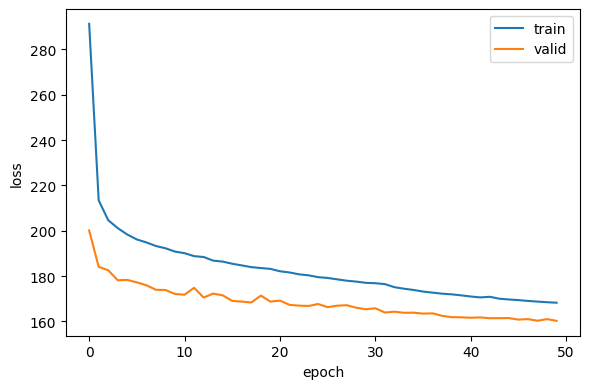

epoch:  0  train_loss:  279.97617571961644   valid_loss:  198.01998901367188
epoch:  10  train_loss:  186.51700817369948   valid_loss:  168.64174417349008
epoch:  20  train_loss:  178.600232741412   valid_loss:  166.25365741436298
epoch:  30  train_loss:  172.9213139964085   valid_loss:  160.11376366248498
epoch:  40  train_loss:  167.9486121196373   valid_loss:  157.43182196983923


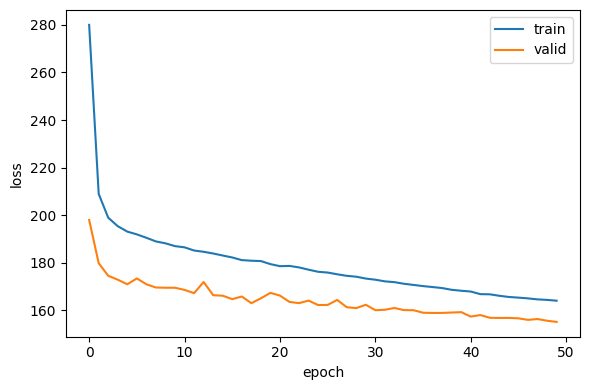

In [30]:
import os

SAVE_DIR = r"C:\Users\chuab\Desktop\Hackathon\models"
activator_gmt = os.path.join(SAVE_DIR, "activator.gmt")
inhibitor_gmt = os.path.join(SAVE_DIR, "inhibitor.gmt")

merged_vega_stim, mw_stim, sw_stim = run_merged_vega_model(
    "vega", PBMC_train, PBMC_valid, "stimulated",
    activator_gmt=activator_gmt,
    inhibitor_gmt=inhibitor_gmt,
    N=1,
    path_to_save=SAVE_DIR
)

merged_vega_ctrl, mw_ctrl, sw_ctrl = run_merged_vega_model(
    "vega", PBMC_train, PBMC_valid, "control",
    activator_gmt=activator_gmt,
    inhibitor_gmt=inhibitor_gmt,
    N=1,
    path_to_save=SAVE_DIR
)


# Plotting function

In [31]:
import os, glob
import pandas as pd

SAVE_DIR = r"C:\Users\chuab\Desktop\Hackathon\models"
os.chdir(SAVE_DIR)

# 1) Find your actual filenames (important: yours may not have underscores)
print("\n".join(sorted(glob.glob("*weight*csv"))))

# ---- set these to match what you actually have on disk ----
stim_mean_fn = "stimulated_merged_vega_weight_mean.csv"
stim_std_fn  = "stimulated_merged_vega_weight_std.csv"
ctrl_mean_fn = "control_merged_vega_weight_mean.csv"
ctrl_std_fn  = "control_merged_vega_weight_std.csv"

mean_stim = pd.read_csv(stim_mean_fn, index_col=0)
std_stim  = pd.read_csv(stim_std_fn,  index_col=0)
mean_ctrl = pd.read_csv(ctrl_mean_fn, index_col=0)
std_ctrl  = pd.read_csv(ctrl_std_fn,  index_col=0)

def read_gmt(gmt_path, sep="\t"):
    d = {}
    with open(gmt_path, "r") as f:
        for line in f:
            parts = line.strip().split(sep)
            if len(parts) >= 3:
                tf = parts[0]
                genes = parts[2:]
                d[tf] = set(genes)
    return d

def gmt_mask_df(weight_df, gmt_dict):
    mask = pd.DataFrame(False, index=weight_df.index, columns=weight_df.columns)
    for tf, genes in gmt_dict.items():
        if tf in mask.columns:
            present = mask.index.intersection(list(genes))
            mask.loc[present, tf] = True
    return mask

act_dict = read_gmt(os.path.join(SAVE_DIR, "activator.gmt"))
inh_dict = read_gmt(os.path.join(SAVE_DIR, "inhibitor.gmt"))

act_mask = gmt_mask_df(mean_stim, act_dict)
inh_mask = gmt_mask_df(mean_stim, inh_dict)

# Keep only edges of that TF_type (others -> NaN so your .dropna() keeps the right genes)
mean_stim_act = mean_stim.where(act_mask)
std_stim_act  = std_stim.where(act_mask)
mean_ctrl_act = mean_ctrl.where(act_mask)
std_ctrl_act  = std_ctrl.where(act_mask)

mean_stim_inh = mean_stim.where(inh_mask)
std_stim_inh  = std_stim.where(inh_mask)
mean_ctrl_inh = mean_ctrl.where(inh_mask)
std_ctrl_inh  = std_ctrl.where(inh_mask)

# Save in the filename pattern your plotting code expects
model = "vega"
mean_stim_act.to_csv(f"stimulated_activator_{model}_weight_mean.csv")
std_stim_act.to_csv (f"stimulated_activator_{model}_weight_std.csv")
mean_ctrl_act.to_csv(f"control_activator_{model}_weight_mean.csv")
std_ctrl_act.to_csv (f"control_activator_{model}_weight_std.csv")

mean_stim_inh.to_csv(f"stimulated_inhibitor_{model}_weight_mean.csv")
std_stim_inh.to_csv (f"stimulated_inhibitor_{model}_weight_std.csv")
mean_ctrl_inh.to_csv(f"control_inhibitor_{model}_weight_mean.csv")
std_ctrl_inh.to_csv (f"control_inhibitor_{model}_weight_std.csv")


control_activator_vega_weight_mean.csv
control_activator_vega_weight_std.csv
control_inhibitor_vega_weight_mean.csv
control_inhibitor_vega_weight_std.csv
control_merged_vega_weight_mean.csv
control_merged_vega_weight_std.csv
control_vega_all_weight_mean.csv
control_vega_all_weight_std.csv
stimulated_activator_vega_weight_mean.csv
stimulated_activator_vega_weight_std.csv
stimulated_inhibitor_vega_weight_mean.csv
stimulated_inhibitor_vega_weight_std.csv
stimulated_merged_vega_weight_mean.csv
stimulated_merged_vega_weight_std.csv
stimulated_vega_all_weight_mean.csv
stimulated_vega_all_weight_std.csv


identifying whether IFN-beta causes these TFs to act as activators or inhibitors in Lupus.

Working directory is now: C:\Users\chuab\Desktop\Hackathon\Project_script


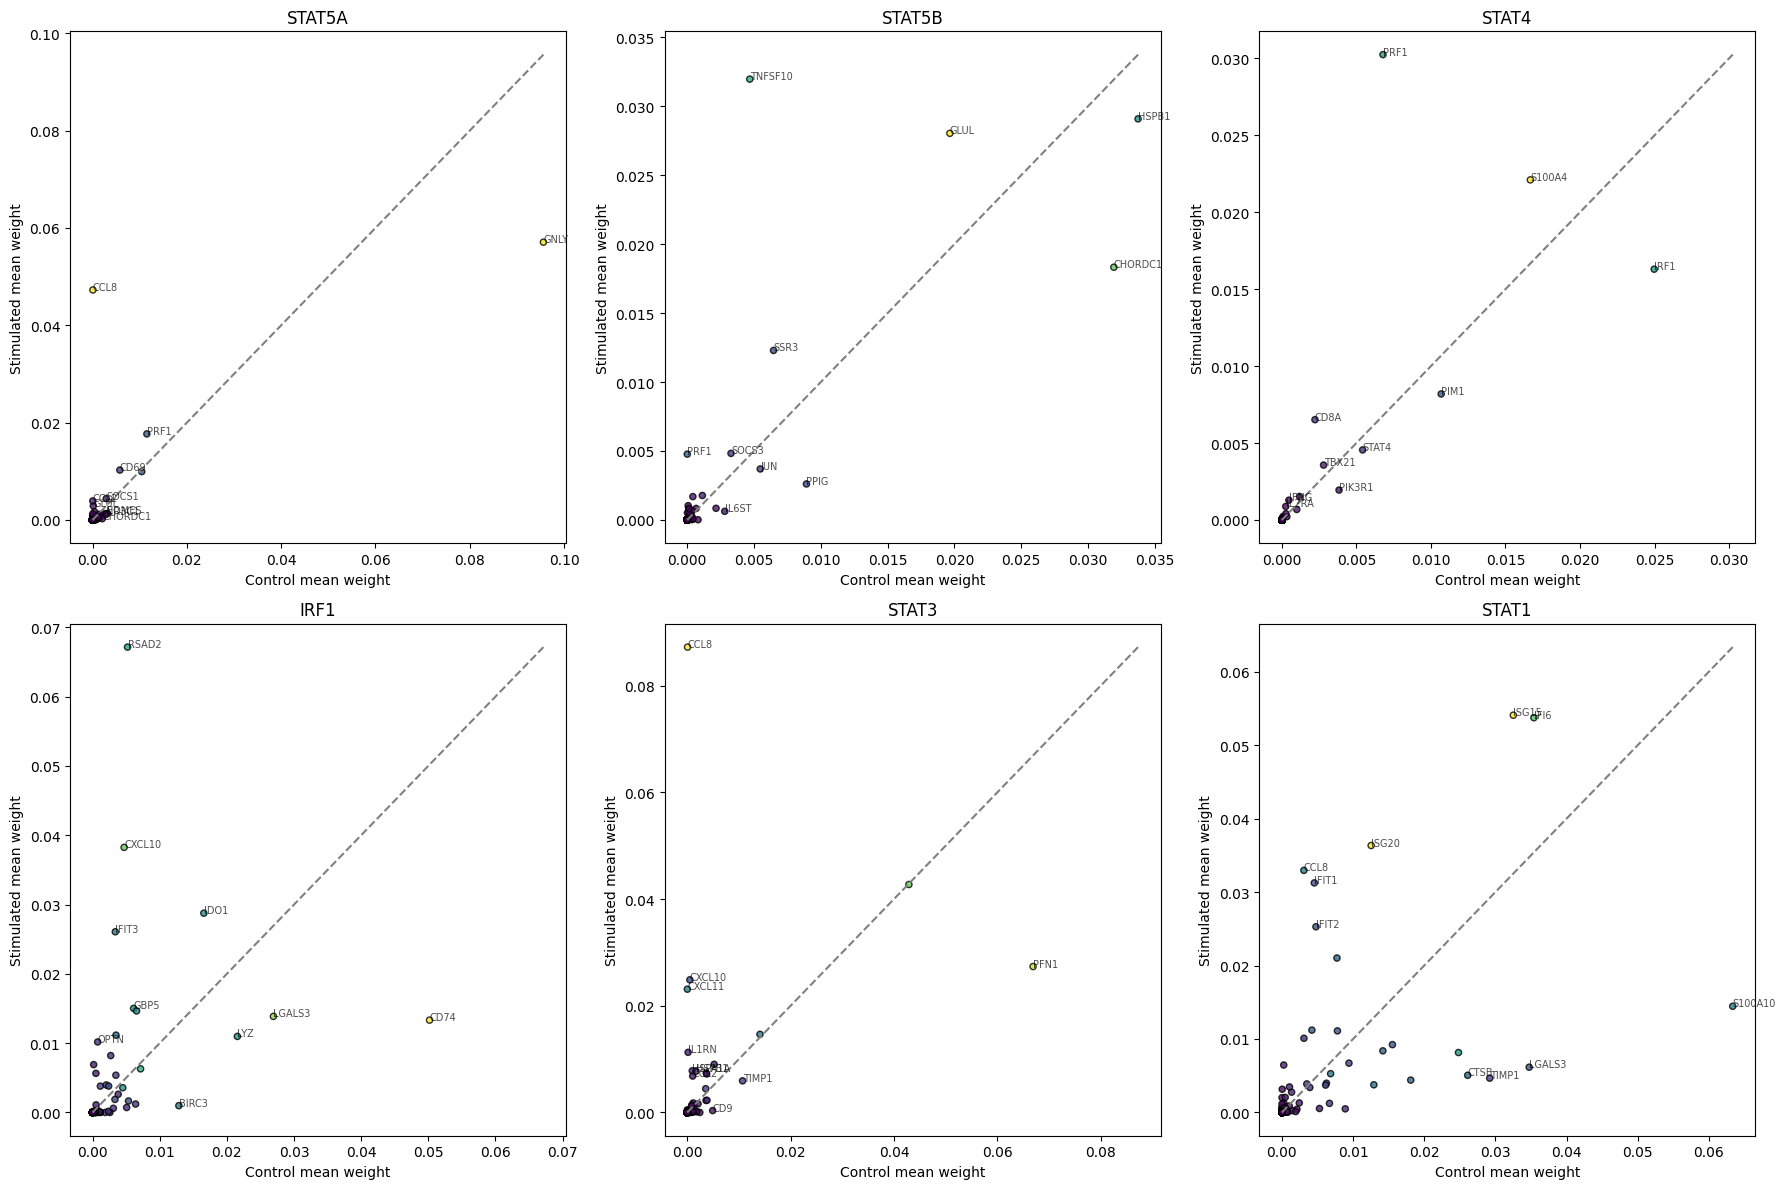

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

SAVE_DIR = r"C:\Users\chuab\Desktop\Hackathon\Project_script"
os.chdir(SAVE_DIR)
print("Working directory is now:", os.getcwd())

## Parameters
TF_names = ['STAT5A', 'STAT5B', 'STAT4', 'IRF1', 'STAT3', 'STAT1']
TF_type = "activator"
model = "vega"

# Load all data once
mean_weight_stim = pd.read_csv(f"stimulated_{TF_type}_{model}_weight_mean.csv", index_col=0)
mean_weight_ctrl = pd.read_csv(f"control_{TF_type}_{model}_weight_mean.csv", index_col=0)
std_weight_stim  = pd.read_csv(f"stimulated_{TF_type}_{model}_weight_std.csv", index_col=0)
std_weight_ctrl  = pd.read_csv(f"control_{TF_type}_{model}_weight_std.csv", index_col=0)

# Plot subplots
n_tfs = len(TF_names)
n_cols = 3
n_rows = (n_tfs + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
if n_rows == 1: axs = axs.reshape(1, -1)  # Ensure 2D array

for idx, TF in enumerate(TF_names):
    row, col = divmod(idx, n_cols)
    ax = axs[row, col]
    
    if TF not in mean_weight_ctrl.columns:
        ax.set_visible(False)
        continue
    
    # Extract for this TF
    stim = mean_weight_stim[TF].rename("stim")
    ctrl = mean_weight_ctrl[TF].rename("ctrl")
    std_stim = std_weight_stim[TF].rename("std_stim")
    std_ctrl = std_weight_ctrl[TF].rename("std_ctrl")
    
    merged = pd.concat([ctrl, stim, std_ctrl, std_stim], axis=1).dropna()
    if merged.empty:
        ax.set_visible(False)
        continue
    
    # Uncertainty
    merged["uncertainty"] = merged[["std_ctrl", "std_stim"]].mean(axis=1)
    
    # Scatter
    sc = ax.scatter(merged["ctrl"], merged["stim"],
                   c=merged["uncertainty"], cmap="viridis",
                   s=20, edgecolor="k", alpha=0.8)
    
    # Diagonal
    mn, mx = min(merged["ctrl"].min(), merged["stim"].min()), max(merged["ctrl"].max(), merged["stim"].max())
    ax.plot([mn, mx], [mn, mx], color='grey', linestyle='--')
    
    # Labels
    ax.set_xlabel("Control mean weight")
    ax.set_ylabel("Stimulated mean weight")
    ax.set_title(f"{TF}")
    
    # Annotate top outliers
    merged["dist"] = np.abs(merged["stim"] - merged["ctrl"]) / np.sqrt(2)
    top = merged.nlargest(10, "dist")  # Top 10 per TF
    for gene, row in top.iterrows():
        ax.annotate(gene, (row["ctrl"], row["stim"]), fontsize=7, alpha=0.7)

plt.tight_layout()
plt.show()


In [33]:
import os
SCRIPT_PATH = r"C:\Users\chuab\Desktop\Hackathon\Project_script"
print("Files in script path:")
print([f for f in os.listdir(SCRIPT_PATH) if f.endswith('_weight_mean.csv')])


Files in script path:
['control_activator_merged_vega_weight_mean.csv', 'control_activator_vega_weight_mean.csv', 'control_STAT_activator_merged_vega_weight_mean.csv', 'control_STAT_activator_vega_weight_mean.csv', 'stimulated_activator_merged_vega_weight_mean.csv', 'stimulated_activator_vega_weight_mean.csv', 'stimulated_STAT_activator_merged_vega_weight_mean.csv', 'stimulated_STAT_activator_vega_weight_mean.csv']


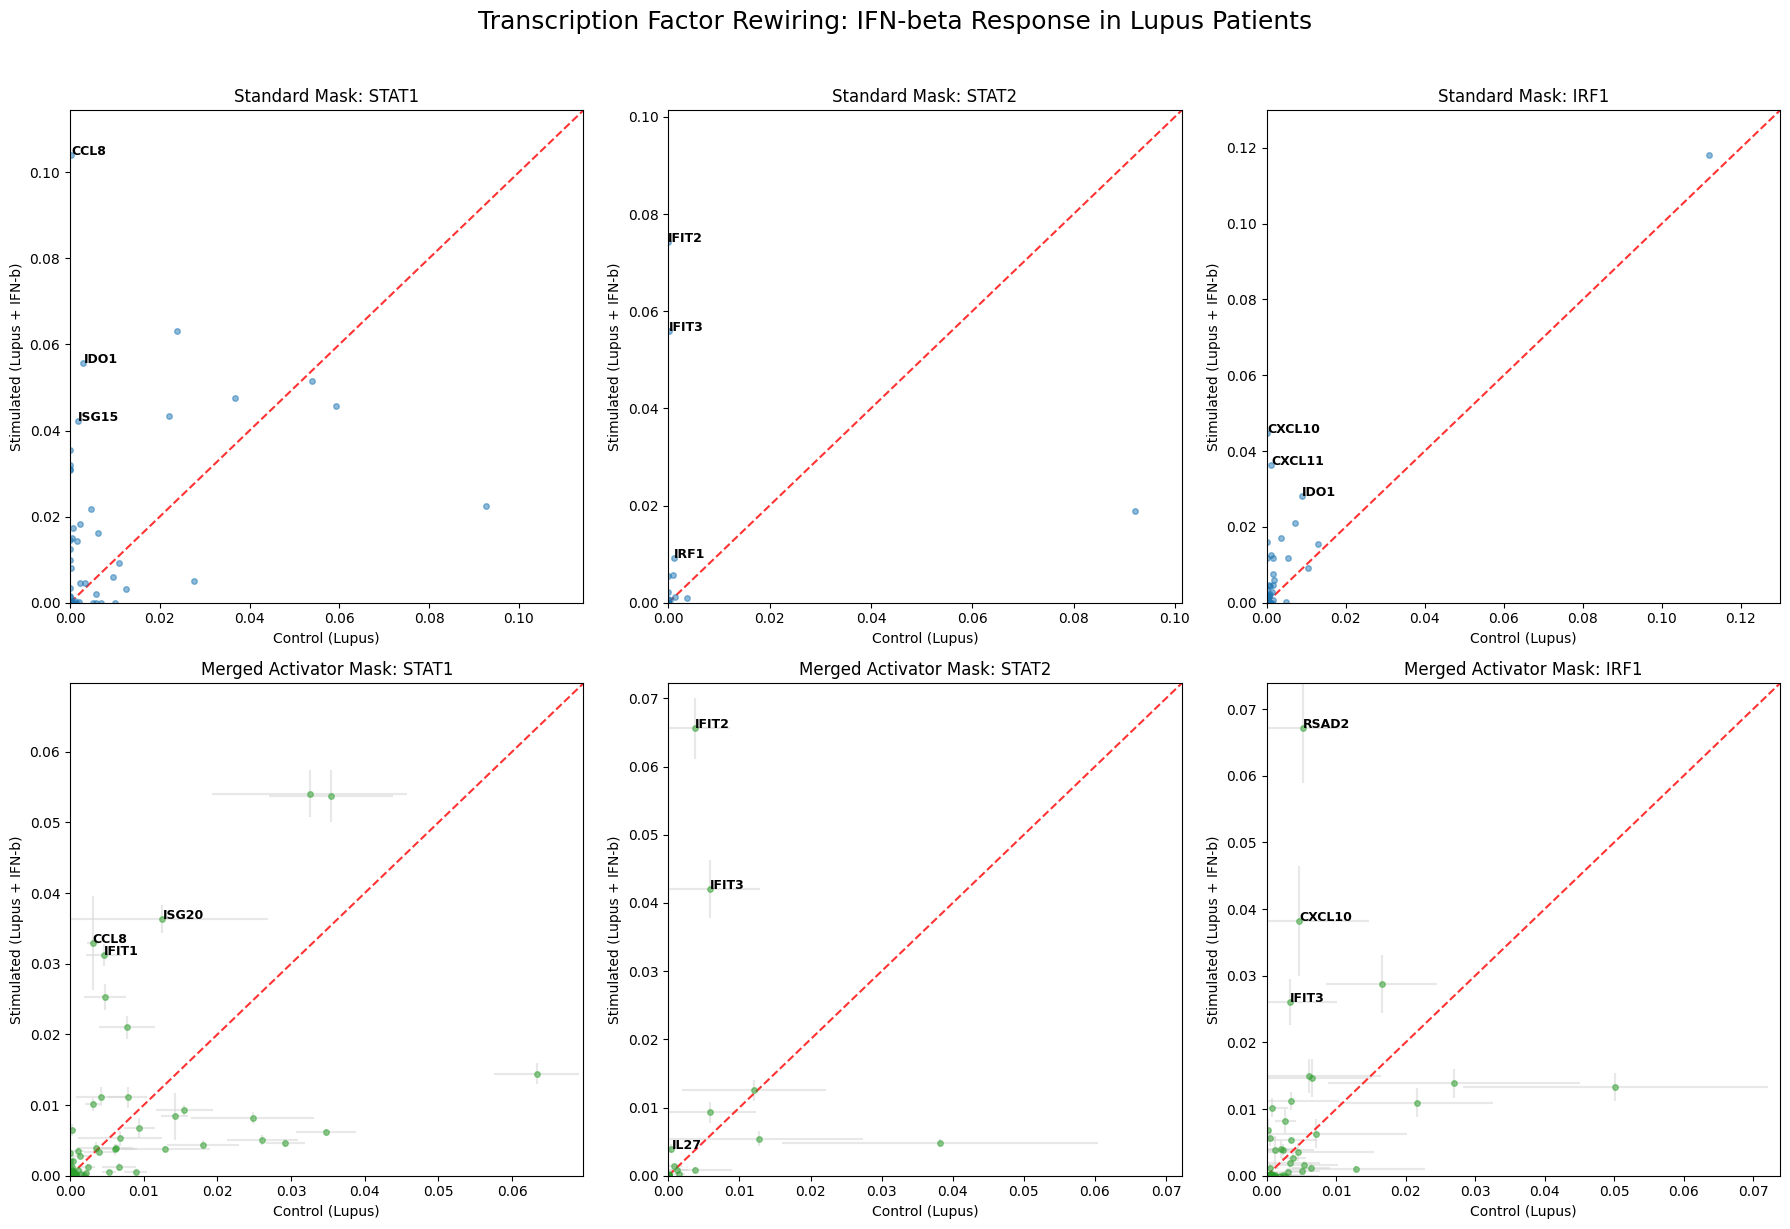


--- TOP REWIRED GENES (IFN-BETA RESPONSE) ---
   TF              Model   Gene  Control_Weight  Stim_Weight  Shift
 IRF1 Merged (Activator)  RSAD2          0.0052       0.0671 0.0619
 IRF1     Standard (All) CXCL10          0.0002       0.0447 0.0446
 IRF1     Standard (All) CXCL11          0.0011       0.0363 0.0352
 IRF1 Merged (Activator) CXCL10          0.0047       0.0382 0.0335
 IRF1 Merged (Activator)  IFIT3          0.0034       0.0261 0.0227
 IRF1     Standard (All)   IDO1          0.0089       0.0283 0.0193
STAT1     Standard (All)   CCL8          0.0002       0.1040 0.1038
STAT1     Standard (All)   IDO1          0.0030       0.0558 0.0528
STAT1     Standard (All)  ISG15          0.0018       0.0422 0.0404
STAT1 Merged (Activator)   CCL8          0.0031       0.0330 0.0299
STAT1 Merged (Activator)  IFIT1          0.0046       0.0313 0.0267
STAT1 Merged (Activator)  ISG20          0.0125       0.0363 0.0238
STAT2     Standard (All)  IFIT2          0.0000       0.0743 0.0743
S

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Paths & Settings
# MASK_DIR: Standard VAE (all gene connections)
# MERGED_DIR: Merged model output filtered for Activators only
MASK_DIR = r"C:\Users\chuab\Desktop\Hackathon\models"
MERGED_DIR = r"C:\Users\chuab\Desktop\Hackathon\Project_script"

TF_NAMES = ['STAT1', 'STAT2', 'IRF1'] 

# Load Data
# Standard "All" files (Top Row)
mask_mean_ctrl = pd.read_csv(os.path.join(MASK_DIR, "control_vega_all_weight_mean.csv"), index_col=0)
mask_mean_stim = pd.read_csv(os.path.join(MASK_DIR, "stimulated_vega_all_weight_mean.csv"), index_col=0)
mask_std_ctrl  = pd.read_csv(os.path.join(MASK_DIR, "control_vega_all_weight_std.csv"), index_col=0)
mask_std_stim  = pd.read_csv(os.path.join(MASK_DIR, "stimulated_vega_all_weight_std.csv"), index_col=0)

# Merged "Activator-Filtered" files (Bottom Row)
merged_mean_ctrl = pd.read_csv(os.path.join(MERGED_DIR, "control_activator_vega_weight_mean.csv"), index_col=0)
merged_mean_stim = pd.read_csv(os.path.join(MERGED_DIR, "stimulated_activator_vega_weight_mean.csv"), index_col=0)
merged_std_ctrl  = pd.read_csv(os.path.join(MERGED_DIR, "control_activator_vega_weight_std.csv"), index_col=0)
merged_std_stim  = pd.read_csv(os.path.join(MERGED_DIR, "stimulated_activator_vega_weight_std.csv"), index_col=0)

# Plotting & Analysis
fig, axs = plt.subplots(2, 3, figsize=(18, 12), squeeze=False)
rewiring_summary = []

def process_and_plot(ax, mean_ctrl, mean_stim, std_ctrl, std_stim, tf, color, label_prefix):
    if tf not in mean_ctrl.columns:
        ax.set_title(f"{tf} Not Found")
        return
    
    # Merge datasets
    df = pd.concat([
        mean_ctrl[tf].rename("ctrl"),
        mean_stim[tf].rename("stim"),
        std_ctrl[tf].rename("std_ctrl"),
        std_stim[tf].rename("std_stim"),
    ], axis=1).dropna()

    # Calculate Rewiring Score (Vertical distance from diagonal)
    df["rewire_score"] = df["stim"] - df["ctrl"]
    
    # Scatter plot with error bars
    ax.errorbar(df["ctrl"], df["stim"], xerr=df["std_ctrl"], yerr=df["std_stim"],
                fmt='o', markersize=4, alpha=0.5, color=color, ecolor='lightgrey')

    # Add diagonal line
    lims = [0, max(df["ctrl"].max(), df["stim"].max()) * 1.1]
    ax.plot(lims, lims, 'r--', alpha=0.8)
    ax.set_xlim(lims); ax.set_ylim(lims)
    
    # Label top 3 rewired genes
    top_3 = df.nlargest(3, "rewire_score")
    for gene, row in top_3.iterrows():
        ax.annotate(gene, (row["ctrl"], row["stim"]), fontsize=9, fontweight='bold')
        rewiring_summary.append({
            "TF": tf, "Model": label_prefix, "Gene": gene, 
            "Control_Weight": round(row["ctrl"], 4), "Stim_Weight": round(row["stim"], 4),
            "Shift": round(row["rewire_score"], 4)
        })

    ax.set_xlabel("Control (Lupus)")
    ax.set_ylabel("Stimulated (Lupus + IFN-b)")

# Run Loops
for i, tf in enumerate(TF_NAMES):
    process_and_plot(axs[0, i], mask_mean_ctrl, mask_mean_stim, mask_std_ctrl, mask_std_stim, tf, 'tab:blue', "Standard (All)")
    axs[0, i].set_title(f"Standard Mask: {tf}")
    
    process_and_plot(axs[1, i], merged_mean_ctrl, merged_mean_stim, merged_std_ctrl, merged_std_stim, tf, 'tab:green', "Merged (Activator)")
    axs[1, i].set_title(f"Merged Activator Mask: {tf}")

plt.suptitle("Transcription Factor Rewiring: IFN-beta Response in Lupus Patients", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# Output Summary Table
summary_df = pd.DataFrame(rewiring_summary)
print("\n--- TOP REWIRED GENES (IFN-BETA RESPONSE) ---")
print(summary_df.sort_values(by=["TF", "Shift"], ascending=[True, False]).to_string(index=False))